In [1]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np
import torch

%load_ext autoreload
%autoreload 2
torch.manual_seed(0)

from IPython.display import clear_output 
clear_output(wait = True)
import sys 
sys.path.append('..\..\..')
from models import LocationScaleFlow, SoftmaxWeight, DIFDensityEstimator,EMDensityEstimator, GeneralizedMultivariateNormalReference
from utils.color_visual import *

(300, 256, 3)


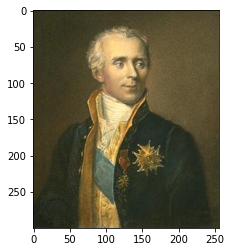

In [2]:
rgb = image.imread("laplace.jpg")
plt.imshow(rgb)
print(rgb.shape)

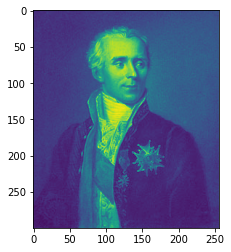

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
grey = torch.tensor(rgb2gray(rgb))
plt.imshow(grey)

In [4]:
vector_density = grey.flatten()
vector_density = vector_density/torch.sum(vector_density)
lignes, colonnes = grey.shape
num_samples = 200000
cat = torch.distributions.Categorical(probs = vector_density)
categorical_samples = cat.sample([num_samples])
target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])

C:\Users\Elouan\AppData\Local\Temp\ipykernel_1208\3527147086.py:7: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  target_samples = torch.cat([(categorical_samples//colonnes).unsqueeze(-1), (categorical_samples%colonnes).unsqueeze(-1)], dim = -1) + torch.rand([num_samples,2])


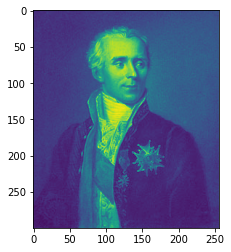

In [5]:
plt.imshow(vector_density.reshape(lignes,colonnes))

<AxesSubplot:xlabel='x', ylabel='y'>

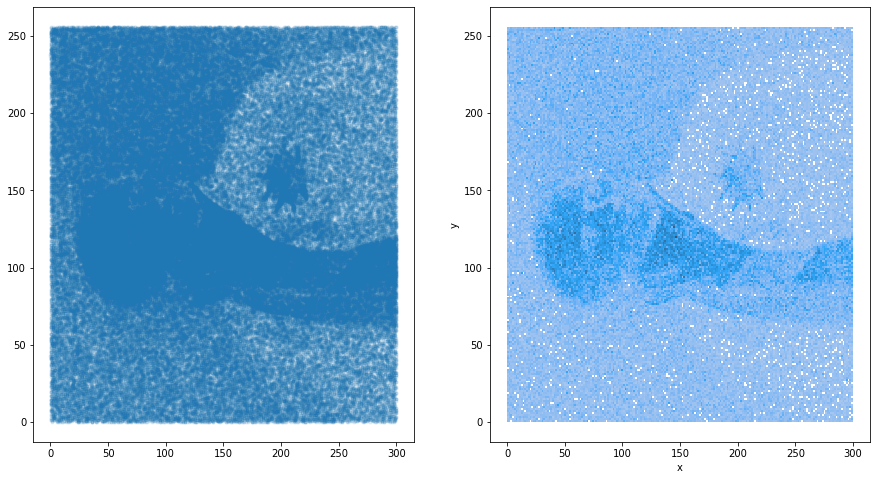

In [6]:
figure = plt.figure(figsize = (15,8))
ax1 = figure.add_subplot(121)
ax1.scatter(target_samples[:,0], target_samples[:, 1], alpha = .1, marker = '.')

import seaborn as sns 
import pandas as pd
ax2 = figure.add_subplot(122)
data_x = pd.DataFrame(target_samples[:,0])
data_x['label'] = 'x'
data_y = pd.DataFrame(target_samples[:,1])
data_y['label'] = 'y'
data = pd.DataFrame()
data['x'] = target_samples[:,0]
data['y'] = target_samples[:,1]
sns.histplot(data, x='x', y='y', bins = (200,200))

c:\users\elouan\pycharmprojects\discretely-indexed-flows\venv\lib\site-packages\torch\functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.10it/s, loss = 11.145832061767578]


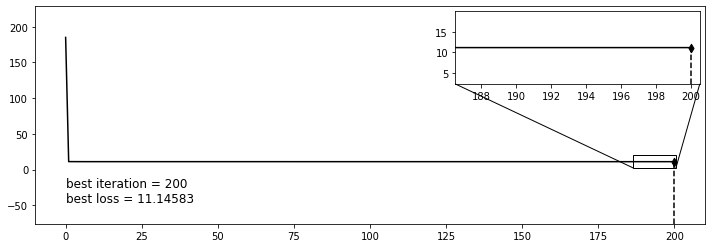

In [7]:
num_samples = target_samples.shape[0]
linspace_x = 7
linspace_y = 7
K = linspace_x*linspace_y
initial_m = torch.cartesian_prod(torch.linspace(0, lignes,linspace_x),torch.linspace(0, colonnes, linspace_y))
initial_L = torch.eye(2).unsqueeze(0).repeat(K, 1, 1)
initial_T = LocationScaleFlow(K, 2, initial_m = initial_m,initial_log_s= initial_L, mode = 'full_rank')
EM = EMDensityEstimator(target_samples,K, initial_T = initial_T)
epochs = 200
loss_values = EM.train(epochs,visual=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [3:24:23<00:00,  1.23s/it, loss = 11.06787395477295]


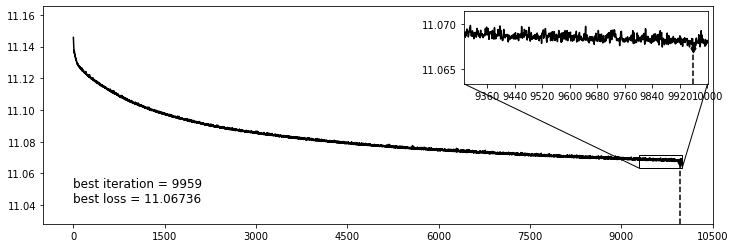

In [8]:
from torch import nn
num_samples = target_samples.shape[0]
epochs = 10000
batch_size = 20000
initial_T = EM.T
initial_w = SoftmaxWeight(K, 2, [64,64,64], mode = 'NN')
initial_w.f[-1].weight = nn.Parameter(torch.zeros(K, 64))
initial_w.f[-1].bias = nn.Parameter(EM.log_pi)
initial_reference = GeneralizedMultivariateNormalReference(2, initial_log_r = torch.log(2.*torch.ones(2)))
dif = DIFDensityEstimator(target_samples,K, initial_T= initial_T, initial_w = initial_w, initial_reference = initial_reference)
loss_values = dif.train(epochs,batch_size,visual=True)

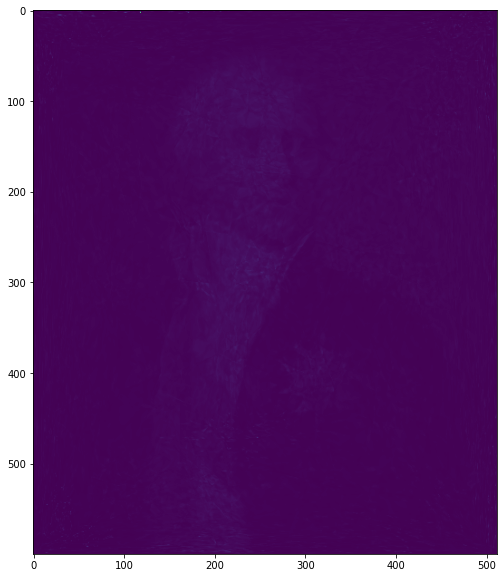

In [9]:
dif_cpu = dif
dif_cpu.to_cpu()
grid = torch.cartesian_prod(torch.linspace(0,lignes,2*lignes),torch.linspace(0,colonnes, 2*colonnes))
density = torch.exp(dif_cpu.log_density(grid)).reshape(2*lignes,2*colonnes).T.cpu().detach()
fig = plt.figure(figsize =(10,10))
plt.imshow(torch.flip(torch.flip(density.T,[0,1]),[0,1]))

In [10]:
loss_values = dif.train(epochs,batch_size,visual=True)

  0%|                                                                                                                                                                                                                                                                                           | 0/10000 [00:03<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
filename_try = 'euler_dif.sav'
pickle.dump(dif, open(filename_try, 'wb'))